In [1]:
!pip install simpy


In [5]:
import simpy
import random
import numpy as np
def queue_simulation(arrival_rate, service_rate, capacity, sim_time):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    wait_times = []

    def customer(env):
        arrival = env.now
        with server.request() as req:
            yield req
            wait_times.append(env.now - arrival)
            yield env.timeout(random.expovariate(service_rate))

    def arrival_process(env):
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(customer(env))

    env.process(arrival_process(env))
    env.run(until=sim_time)

    return np.mean(wait_times) if wait_times else 0

import pandas as pd

data = []

for _ in range(1000):
    ar = random.uniform(0.5, 5)
    sr = random.uniform(1, 6)
    cap = random.randint(5, 50)
    sim_time = random.randint(50, 200)

    avg_wait = queue_simulation(ar, sr, cap, sim_time)

    data.append([ar, sr, cap, sim_time, avg_wait])

df = pd.DataFrame(data, columns=[
    "arrival_rate", "service_rate", "queue_capacity",
    "simulation_time", "avg_wait_time"
])

df.head()
df.describe()
df.to_csv("simulation_data.csv", index=False)

# ================================
# PHASE 2: Define ML Problem
# ================================

X = df.drop("avg_wait_time", axis=1)
y = df["avg_wait_time"]

# ================================
# PHASE 3: Train-Test Split
# ================================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ================================
# PHASE 4: Train & Compare Models
# ================================

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)

    results.append([name, mae, mse, r2])

results_df = pd.DataFrame(
    results, columns=["Model", "MAE", "MSE", "R2 Score"]
)

results_df
results_df.to_csv("model_comparison_results.csv", index=False)




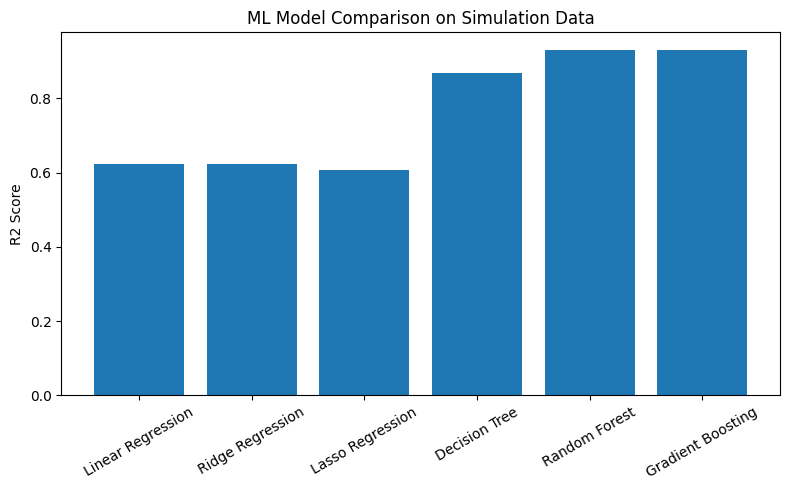

,Model,MAE,MSE,R2 Score
5,Gradient Boosting,2.133567,15.052626,0.931015
4,Random Forest,1.994912,15.531653,0.928820
3,Decision Tree,2.595112,28.619999,0.868837
0,Linear Regression,6.629041,82.517498,0.621830
1,Ridge Regression,6.628453,82.529187,0.621776
2,Lasso Regression,6.593196,85.531888,0.608015


<Figure size 640x480 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.xticks(rotation=30)
plt.ylabel("R2 Score")
plt.title("ML Model Comparison on Simulation Data")
plt.tight_layout()
plt.show()

plt.savefig("model_comparison_r2.png")
results_df.sort_values(by="R2 Score", ascending=False)

